# MY FIRST GAN

##### All the code has taken from real python website. I'll provide the break down and explain of each line of code and also make a video out of it.

In [27]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

###### It’s a good set up a random generator seed so that the experiment can be replicated identically on any machine.

In [28]:
#The number 111 represents the random seed used to initialize the random number generator, which is used to initialize the neural network’s weights.
torch.manual_seed(111)

## Preparing the Training Data

In [29]:
train_data_length = 1024
#initialize train_data, a tensor with dimensions of 1024 rows and 2 columns, 
#all containing zeros.
train_data = torch.zeros((train_data_length, 2))
#first column of train_data to store random values in the interval from 0 to 2π.
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
#calculate the second column of the tensor as the sine of the first column.
train_data[:, 1] = torch.sin(train_data[:, 0])
#create train_labels, a tensor filled with zeros. 
train_labels = torch.zeros(train_data_length)
#create train_set as a list of tuples, with each row of train_data and train_labels represented in each tuple as expected by PyTorch’s data loader.
train_set = [

    (train_data[i], train_labels[i]) for i in range(train_data_length)

]

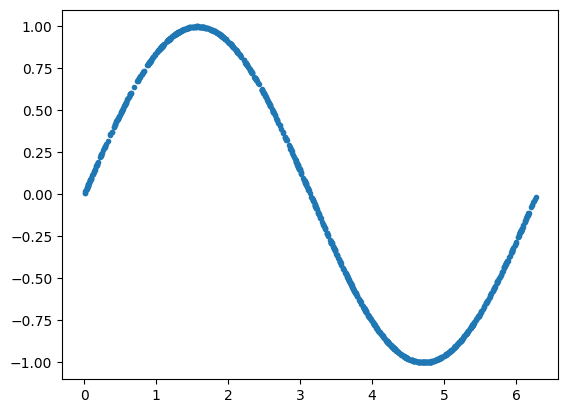

In [30]:
#plotting each point (x₁, x₂)
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [31]:
#create a data loader called train_loader, which will shuffle the data from train_set and return batches of 32 samples that you’ll use to train the neural networks.
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

# Implementing the Discriminator

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #The input is two-dimensional, and the first hidden layer is composed of 256 neurons with ReLU activation.
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            #The second and third hidden layers are composed of 128 and 64 neurons, respectively, with ReLU activation.
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            #The output is composed of a single neuron with sigmoidal activation to represent a probability.
            nn.Linear(128, 64),
            nn.ReLU(),
            # After the first, second, and third hidden layers, you use dropout to avoid overfitting.(see upper dropouts)
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [33]:
#instantiate a Discriminator 
discriminator = Discriminator()

# Implementing the Generator

##### Here, generator represents the generator neural network. It’s composed of two hidden layers with 16 and 32 neurons, both with ReLU activation, and a linear activation layer with 2 neurons in the output. This way, the output will consist of a vector with two elements that can be any value ranging from negative infinity to infinity, which will represent (x̃₁, x̃₂).

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

# Training the Models

In [35]:
#sets the learning rate (lr), which you’ll use to adapt the network weights.
lr = 0.001
#sets the number of epochs (num_epochs), which defines how many repetitions of training using the whole training set will be performed.
num_epochs = 300
#assigns the variable loss_function to the binary cross-entropy function BCELoss(), which is the loss function that you’ll use to train the models.
loss_function = nn.BCELoss()

### PyTorch implements various weight update rules for model training in torch.optim. The Adam algorithm will train the discriminator and generator models. To create the optimizers using torch.optim

In [36]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

### need to implement a training loop in which training samples are fed to the models, and their weights are updated to minimize the loss function

In [39]:
for epoch in range(num_epochs):
    #You get the real samples of the current batch from the data loader and assign them to real_samples. Notice that the first dimension of the tensor has the number of elements equal to batch_size. This is the standard way of organizing data in PyTorch, with each line of the tensor representing one sample from the batch.
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        #You use torch.ones() to create labels with the value 1 for the real samples, and then you assign the labels to real_samples_labels.
        real_samples_labels = torch.ones((batch_size, 1))
        #You create the generated samples by storing random data in latent_space_samples, which you then feed to the generator to obtain generated_samples.
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        #You use torch.zeros() to assign the value 0 to the labels for the generated samples, and then you store the labels in generated_samples_labels.
        generated_samples_labels = torch.zeros((batch_size, 1))
        #You concatenate the real and generated samples and labels and store them in all_samples and all_samples_labels, which you’ll use to train the discriminator.
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        #In PyTorch, it’s necessary to clear the gradients at each training step to avoid accumulating them. You do this using .zero_grad().
        discriminator.zero_grad()
        #You calculate the output of the discriminator using the training data in all_samples.
        output_discriminator = discriminator(all_samples)
        #You calculate the loss function using the output from the model in output_discriminator and the labels in all_samples_labels.
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        #You calculate the gradients to update the weights with loss_discriminator.backward().
        loss_discriminator.backward()
        #You update the discriminator weights by calling optimizer_discriminator.step().
        optimizer_discriminator.step()

        # Data for training the generator
        # prepare the data to train the generator. You store random data in latent_space_samples, with a number of lines equal to batch_size. You use two columns since you’re providing two-dimensional data as input to the generator.
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        #You clear the gradients with .zero_grad().
        generator.zero_grad()
        #You feed the generator with latent_space_samples and store its output in generated_samples.
        generated_samples = generator(latent_space_samples)
        #feed the generator’s output into the discriminator and store its output in output_discriminator_generated, which you’ll use as the output of the whole model.
        output_discriminator_generated = discriminator(generated_samples)
        #calculate the loss function using the output of the classification system stored in output_discriminator_generated and the labels in real_samples_labels, which are all equal to 1.
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        #calculate the gradients and update the generator weights. Remember that when you trained the generator, you kept the discriminator weights frozen since you created optimizer_generator with its first argument equal to generator.parameters().
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        #display the values of the discriminator and generator loss functions at the end of each ten epochs.
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.725507378578186
Epoch: 0 Loss G.: 0.767403244972229
Epoch: 10 Loss D.: 0.659313440322876
Epoch: 10 Loss G.: 0.899202287197113
Epoch: 20 Loss D.: 0.6053537130355835
Epoch: 20 Loss G.: 1.044240951538086
Epoch: 30 Loss D.: 0.7441221475601196
Epoch: 30 Loss G.: 0.7511733770370483
Epoch: 40 Loss D.: 0.6721683740615845
Epoch: 40 Loss G.: 0.7095950841903687
Epoch: 50 Loss D.: 0.7082590460777283
Epoch: 50 Loss G.: 0.7670279741287231
Epoch: 60 Loss D.: 0.644618570804596
Epoch: 60 Loss G.: 0.9682708978652954
Epoch: 70 Loss D.: 0.6589652895927429
Epoch: 70 Loss G.: 0.7280973792076111
Epoch: 80 Loss D.: 0.641819953918457
Epoch: 80 Loss G.: 0.7449513077735901
Epoch: 90 Loss D.: 0.66912841796875
Epoch: 90 Loss G.: 0.7676193714141846
Epoch: 100 Loss D.: 0.6127502918243408
Epoch: 100 Loss G.: 1.036947250366211
Epoch: 110 Loss D.: 0.6753268241882324
Epoch: 110 Loss G.: 0.7069239616394043
Epoch: 120 Loss D.: 0.7244952917098999
Epoch: 120 Loss G.: 0.7222408056259155
Epoch: 130 Loss D.

## Checking the Samples Generated by the GAN

##### Generative adversarial networks are designed to generate data. So, after the training process is finished, you can get some random samples from the latent space and feed them to the generator to obtain some generated samples

In [40]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

##### Then you can plot the generated samples and check if they resemble the training data. Before plotting the generated_samples data, you’ll need to use .detach() to return a tensor from the PyTorch computational graph, which you’ll then use to calculate the gradients

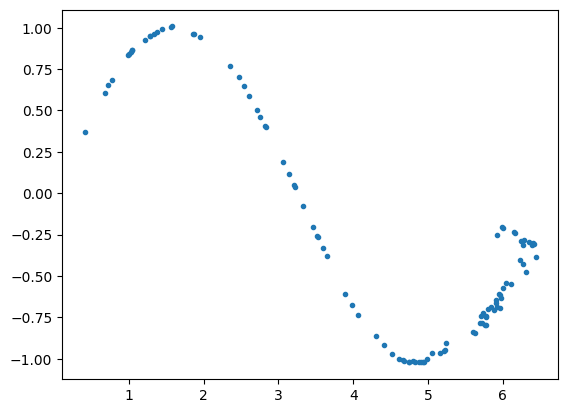

In [41]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")